# Tabular Playground Series - Jul 2022 by Kaggle

### Dataset Description

For this challenge, you are given (simulated) manufacturing control data that can be clustered into different control states. Your task is to cluster the data into these control states. You are not given any training data, and you are not told how many possible control states there are. This is a completely unsupervised problem, one you might encounter in a real-world setting.

Good luck!

Files
data.csv - the file includes continuous and categorical data; your task is to predict which rows should be clustered together in a control state
sample_submission.csv - a sample submission file in the correct format, where Predicted is the predicted control state

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

In [2]:
df = pd.read_csv('wrangled_data.csv')

### Exploratory Data Analysis and wrangling were performed earlier, you can find full description in previous file tpsWrangling_EDA.ipynb.
Please check [GitHub](https://github.com/raz0r-b1ade/TPSProject/blob/main/tpsWrangling_EDA.ipynb)

In [3]:
df

,id,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,0,-0.836112,1.274776,0.993309,-0.508601,1.096162,-0.051693,0.159727,-0.711585,0.911572,-0.680948,0.762783,0.960482,1.045296,0.683323
1,1,-0.836112,-0.768434,-0.146184,-0.772055,-0.357793,1.649274,0.711794,-0.541815,0.454693,1.032386,-0.133948,-0.552942,0.355435,-1.602671
2,2,0.087707,0.964150,-0.343259,0.151717,0.326170,-0.860202,1.023533,2.236943,0.088090,-1.513324,-0.577814,0.979171,-0.926250,-2.224327
3,3,0.319952,-1.124101,0.876903,0.151717,0.326170,-0.051693,-0.302435,0.727667,-1.218753,0.825698,-1.164842,-0.397908,-0.114228,0.307002
4,4,0.726239,0.237344,-0.343259,-1.071337,-2.056959,1.221275,1.023533,0.218614,-1.484025,0.847369,-0.622034,1.166086,-0.385886,-1.149094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97995,97995,0.087707,0.237344,0.196742,-0.508601,-0.115881,-0.051693,0.358140,0.952911,0.408781,1.287093,-0.091769,-0.989367,0.153191,0.442240
97996,97996,-0.472485,0.622160,-1.136434,-0.508601,-1.220894,0.905917,1.167464,1.163371,-0.428415,0.267485,0.778516,0.138325,0.686528,0.627132
97997,97997,0.726239,0.622160,0.492398,-0.051810,-0.618213,-0.556159,-0.583940,-0.994402,1.448745,0.866627,0.164508,1.544230,1.185513,0.570752
97998,97998,-1.326206,0.436089,0.627263,0.695233,-1.220894,0.558332,-0.058277,0.268791,0.513515,0.685678,-0.300550,-1.084287,-0.547494,0.107754


In [4]:
df.describe()

,id,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_22,f_23,f_24,f_25,f_26,f_27,f_28
count,98000.000000,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04,9.800000e+04
mean,48999.500000,4.364763e-17,-2.865372e-16,-1.200672e-16,1.377583e-16,-2.067462e-16,-5.481330e-17,7.540454e-18,7.105427e-18,-1.421085e-17,1.986619e-17,-6.597897e-18,-3.915235e-18,4.712783e-18,-1.392084e-17
std,28290.307527,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,0.000000,-2.706787e+00,-2.798281e+00,-2.847376e+00,-3.018366e+00,-3.039661e+00,-2.965057e+00,-2.675209e+00,-4.625127e+00,-5.361355e+00,-5.157982e+00,-4.142901e+00,-5.121103e+00,-5.694826e+00,-4.398679e+00
25%,24499.750000,-4.724848e-01,-4.711901e-01,-5.650300e-01,-5.086008e-01,-6.182129e-01,-5.561587e-01,-5.839398e-01,-6.659755e-01,-6.577357e-01,-6.933338e-01,-6.755105e-01,-6.394323e-01,-6.472814e-01,-6.749869e-01
50%,48999.500000,8.770685e-02,2.304099e-02,3.247327e-02,-5.181050e-02,1.112382e-01,-5.169305e-02,1.597273e-01,-1.213596e-02,6.397907e-04,4.149117e-04,-2.215139e-02,-5.820545e-03,-1.244215e-02,-2.643729e-02
75%,73499.250000,7.262392e-01,6.221605e-01,6.272635e-01,6.952334e-01,7.266568e-01,7.367507e-01,7.117935e-01,6.556212e-01,6.587329e-01,6.811371e-01,6.674753e-01,6.342589e-01,6.333945e-01,6.551825e-01
max,97999.000000,3.591149e+00,3.260233e+00,3.331381e+00,3.674836e+00,3.317073e+00,3.956507e+00,3.068595e+00,4.436492e+00,4.197696e+00,4.770452e+00,4.827834e+00,4.949518e+00,5.444689e+00,4.715872e+00


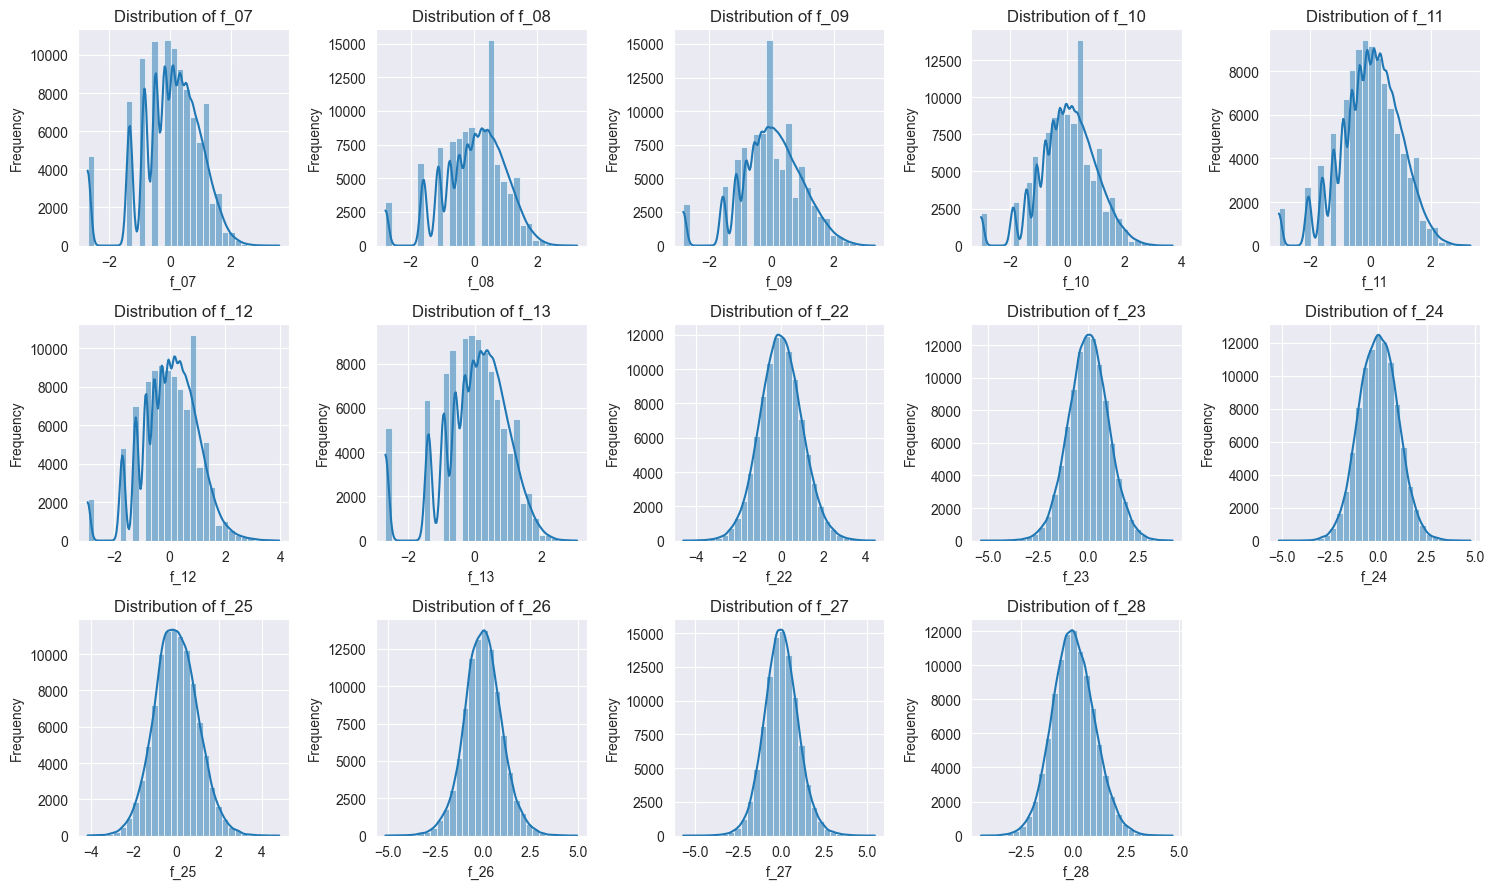

In [5]:
# All feature columns (excluding the 'id' column)
feature_columns = df.columns[1:]

# Number of rows and columns for subplots
n_rows = len(feature_columns) // 5 + (1 if len(feature_columns) % 5 != 0 else 0)

plt.figure(figsize=(15, 3 * n_rows))
for i, col in enumerate(feature_columns, 1):
    plt.subplot(n_rows, 5, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

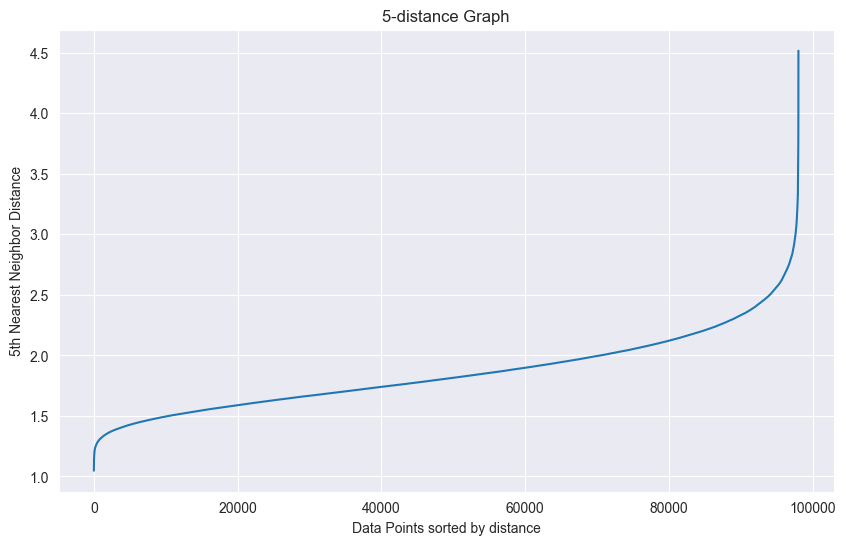

In [6]:
X = df.drop('id', axis=1)

# Step 1: Compute the kth nearest neighbor distance for each point
# We'll set k to 5 as an example. You can adjust this based on your data and intended min_samples for DBSCAN.
k = 5
neigh = NearestNeighbors(n_neighbors=k)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

# Get the distance of the kth neighbor for each point (sorted)
sorted_distances = np.sort(distances[:, k-1])

# Step 2: Plot the k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(range(len(sorted_distances)), sorted_distances)
plt.xlabel('Data Points sorted by distance')
plt.ylabel(f'{k}th Nearest Neighbor Distance')
plt.title(f'{k}-distance Graph')
plt.grid(True)
plt.show()

Determining the Optimal eps Parameter with the k-distance Graph
DBSCAN requires two primary parameters: eps and min_samples. While min_samples often depends on domain knowledge, eps can be tricky to set. The k-distance graph helps us determine a good value for eps.

By calculating the distance to the kth nearest neighbor for each data point, we can plot these distances in ascending order.
An 'elbow' or inflection point in this graph gives a hint for a suitable eps value. It represents a threshold where data points have significantly more distant kth neighbors, indicating potential cluster boundaries or noise.

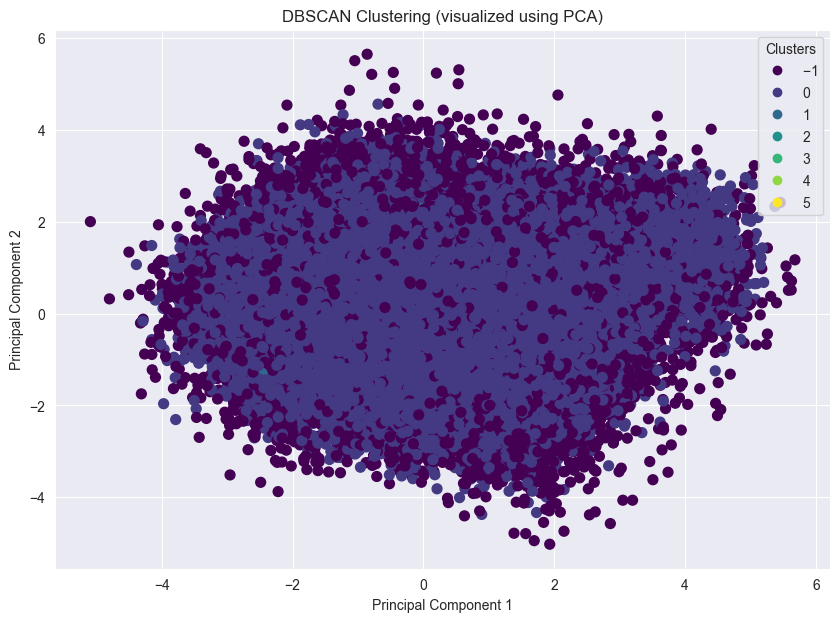

(6, 15108)

In [7]:
# Apply DBSCAN clustering
db = DBSCAN(eps=2.00, min_samples=7).fit(X)

# Add the cluster labels to the dataframe
df['DBSCAN_cluster'] = db.labels_

# Use PCA for visualization (reduce to 2 dimensions)
pca = PCA(n_components=2)
df_pca = pca.fit_transform(X)

# Plot the clusters
plt.figure(figsize=(10, 7))
scatter = plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df['DBSCAN_cluster'], cmap='viridis', s=50)
legend1 = plt.legend(*scatter.legend_elements(), loc="upper right", title="Clusters")
plt.title('DBSCAN Clustering (visualized using PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# Number of clusters and noise points
n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
n_noise_ = list(db.labels_).count(-1)

n_clusters_, n_noise_

Using the DBSCAN algorithm, we:

Apply clustering to the dataset with the chosen parameters.
Assign each data point to a cluster or mark it as noise (labeled as -1).
Visualization of Clusters using PCA
High-dimensional data is challenging to visualize. To overcome this:

We use Principal Component Analysis (PCA) to reduce the dataset's dimensionality to two components.
We then visualize the clusters in this 2D space, giving us an intuitive understanding of how DBSCAN has grouped our data.
Insights from the Clustering Process
Finally, it's essential to understand the results:

We determine the number of unique clusters found (6).
We also identify how many data points are considered 'noise' by the algorithm, i.e., points that didn't fit well into any cluster. (15108)

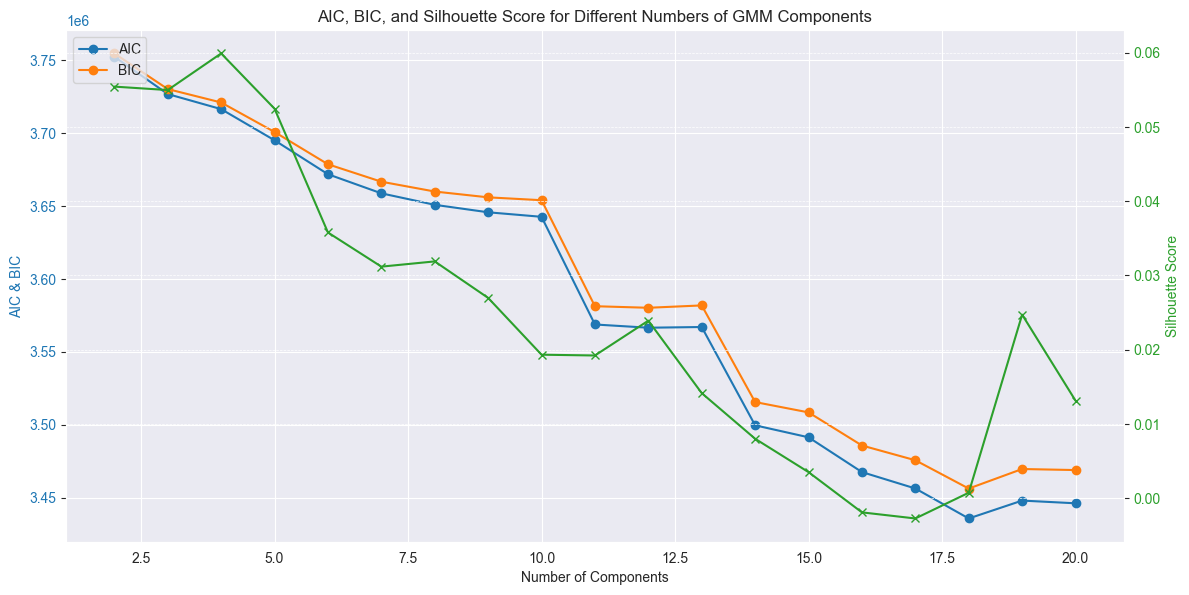

In [8]:
n_components_range = range(2, 21)  # Starting from 2 because silhouette score requires at least 2 clusters
aic_scores = []
bic_scores = []
sil_scores = []

for n_components in n_components_range:
    # Fit the GMM model
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(X)

    # Predict the cluster labels
    labels = gmm.predict(X)

    # Compute AIC and BIC for the current model
    aic_scores.append(gmm.aic(X))
    bic_scores.append(gmm.bic(X))

    # Compute silhouette score for the current clustering
    sil_scores.append(silhouette_score(X, labels))

# Plot AIC, BIC, and silhouette scores
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('AIC & BIC', color=color)
ax1.plot(n_components_range, aic_scores, 'o-', label='AIC', color='tab:blue')
ax1.plot(n_components_range, bic_scores, 'o-', label='BIC', color='tab:orange')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(n_components_range, sil_scores, 'x-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('AIC, BIC, and Silhouette Score for Different Numbers of GMM Components')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

Determining the Number of Components:
When using Gaussian Mixture Models for clustering, one of the primary decisions is determining the number of Gaussian components (or clusters). In this context, we evaluate the model's fit for a range of components, from 2 to 20. We chose to start at 2 because the silhouette score, one of our evaluation metrics, requires at least 2 clusters.

Iterative Model Evaluation:
For each potential number of components:

Model Fitting:
A GMM is fit to the data (X) with the current number of components.
Cluster Prediction:
We predict cluster labels for the data based on the fitted GMM.
Evaluation Metrics Computation:
AIC (Akaike Information Criterion): Represents the goodness of fit of the model. Lower AIC values suggest better-fitting models.
BIC (Bayesian Information Criterion): Similar to AIC but includes a penalty for models with more parameters. Like AIC, smaller BIC values are preferable.
Silhouette Score: Measures how close each sample in one cluster is to the samples in the neighboring clusters. Its values range from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
Visualizing the Evaluation Metrics:
The computed AIC, BIC, and silhouette scores are plotted against the number of components:

The AIC and BIC scores are plotted on the primary y-axis, with distinct markers and colors for clarity. Both these metrics help in model selection; models with lower AIC/BIC are typically favored.
The silhouette score is plotted on a secondary y-axis. A higher silhouette score indicates better-defined clusters.
A grid is added to the background for better visualization and comparison across different numbers of components.
Interpreting the Visualization:
Points where the AIC or BIC curve reaches a minimum might suggest an optimal number of components.
The silhouette score gives an independent perspective on the clustering quality. Ideally, you'd look for a number of components where the silhouette score is high and the AIC/BIC are relatively low.

In [40]:
# Fit a GMM with 10 components
gmm = GaussianMixture(n_components=17, random_state=0)
df['GMM_cluster'] = gmm.fit_predict(df.drop('id', axis=1))

In [10]:
df[['id', 'DBSCAN_cluster', 'GMM_cluster']]

,id,DBSCAN_cluster,GMM_cluster
0,0,0,3
1,1,0,3
2,2,0,3
3,3,0,0
4,4,0,0
...,...,...,...
97995,97995,0,3
97996,97996,0,0
97997,97997,0,0
97998,97998,0,3


In [38]:
submission_df_0 = df[['id', 'DBSCAN_cluster']].copy()
submission_df_0.columns = ['id', 'predicted']
# Save to submission.csv
submission_df_0.to_csv('DB_submission.csv', index=False)

In [41]:
submission_df_1 = df[['id', 'GMM_cluster']].copy()
submission_df_1.columns = ['id', 'predicted']
# Save to submission.csv
submission_df_1.to_csv('GMM_submission.csv', index=False)

[](DB_GMM.png)

In [2]:
df_wh = pd.read_csv('wrangled_wh_data.csv')

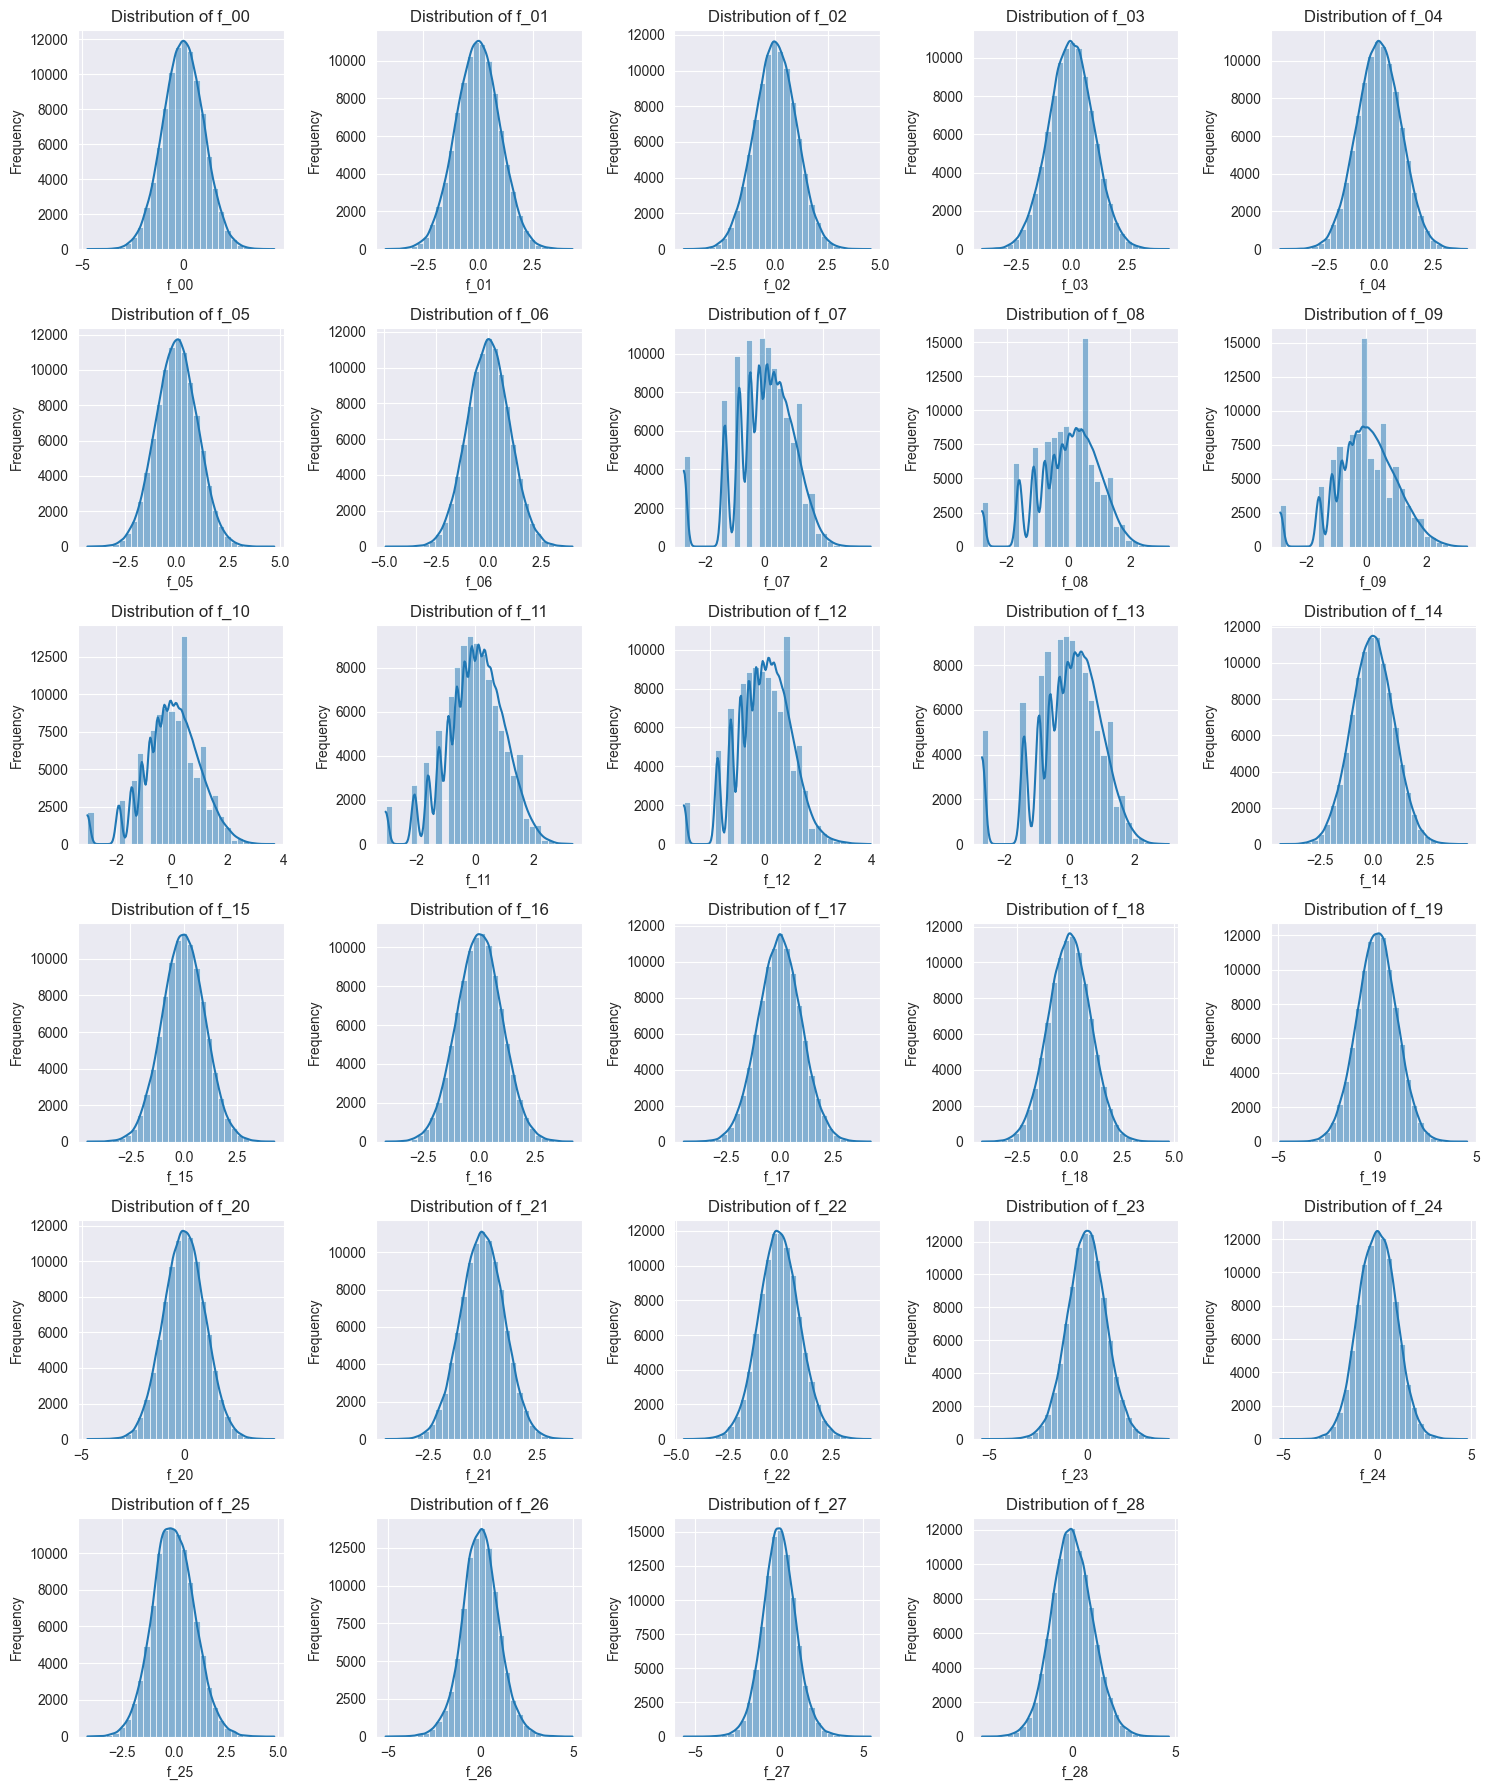

In [3]:
# All feature columns (excluding the 'id' column)
feature_columns = df_wh.columns[1:]

# Number of rows and columns for subplots
n_rows = len(feature_columns) // 5 + (1 if len(feature_columns) % 5 != 0 else 0)

plt.figure(figsize=(15, 3 * n_rows))
for i, col in enumerate(feature_columns, 1):
    plt.subplot(n_rows, 5, i)
    sns.histplot(df_wh[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

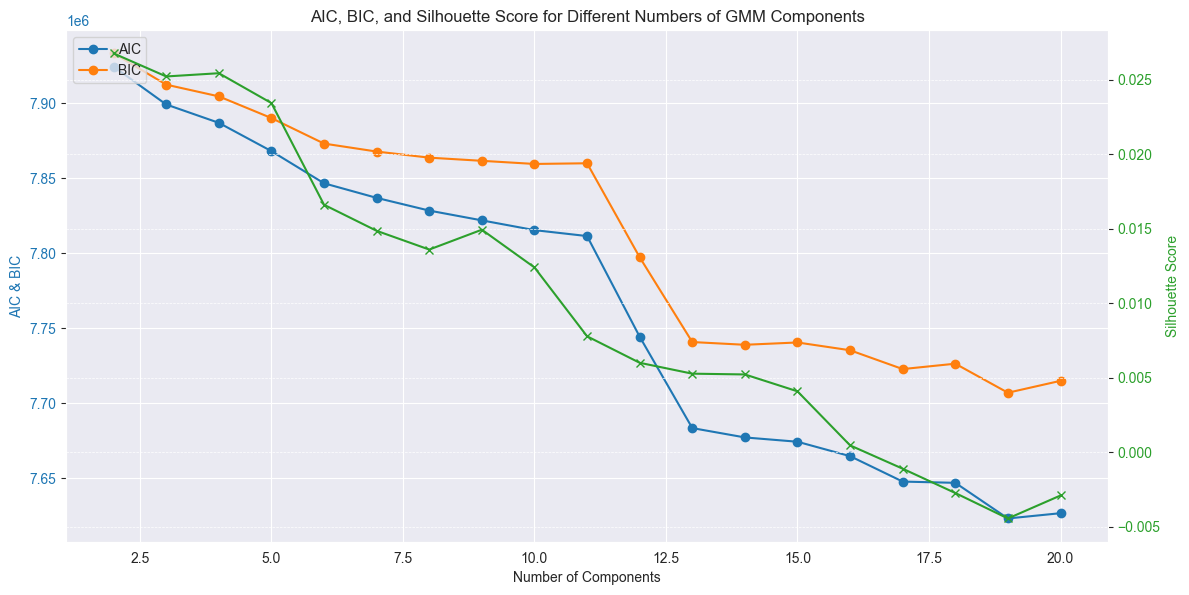

In [5]:
X_wh = df_wh.drop('id', axis=1)

n_components_range = range(2, 21)  # Starting from 2 because silhouette score requires at least 2 clusters
aic_scores = []
bic_scores = []
sil_scores = []

for n_components in n_components_range:
    # Fit the GMM model
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(X_wh)

    # Predict the cluster labels
    labels = gmm.predict(X_wh)

    # Compute AIC and BIC for the current model
    aic_scores.append(gmm.aic(X_wh))
    bic_scores.append(gmm.bic(X_wh))

    # Compute silhouette score for the current clustering
    sil_scores.append(silhouette_score(X_wh, labels))

# Plot AIC, BIC, and silhouette scores
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('AIC & BIC', color=color)
ax1.plot(n_components_range, aic_scores, 'o-', label='AIC', color='tab:blue')
ax1.plot(n_components_range, bic_scores, 'o-', label='BIC', color='tab:orange')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(n_components_range, sil_scores, 'x-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('AIC, BIC, and Silhouette Score for Different Numbers of GMM Components')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [15]:
# Fit a GMM with n components
gmm = GaussianMixture(n_components=11, random_state=0)
df_wh['GMM_cluster'] = gmm.fit_predict(df_wh.drop('id', axis=1))

In [16]:
submission_df_2 = df_wh[['id', 'GMM_cluster']].copy()
submission_df_2.columns = ['id', 'predicted']
# Save to submission.csv
submission_df_2.to_csv('GMM_wh_submission.csv', index=False)

GMM_wh_submission.csv
Complete (after deadline) · 3h ago
0.20627

0.20503

GMM_wh_submission.csv
Complete (after deadline) · 4h ago
0.20941

0.20765

GMM_wh_submission.csv
Complete (after deadline) · 4h ago
0.15421

0.15288

GMM_wh_submission.csv
Complete (after deadline) · 4h ago
0.30209

0.30021

GMM_wh_submission.csv
Complete (after deadline) · 4h ago
0.44753

0.44737

GMM_submission.csv
Complete (after deadline) · 5h ago
0.20255

0.20369

GMM_submission.csv
Complete (after deadline) · 5h ago
0.20721

0.20813

GMM_submission.csv
Complete (after deadline) · 5h ago
0.18355

0.18445

GMM_submission.csv
Complete (after deadline) · 5h ago
0.22658

0.22781

GMM_submission.csv
Complete (after deadline) · 5h ago
0.25447

0.25549

GMM_submission.csv
Complete (after deadline) · 5h ago
0.09942

0.09696

GMM_submission.csv
Complete (after deadline) · 5h ago
0.09229

0.08841

GMM_submission.csv
Complete (after deadline) · 5h ago
0.10189

0.09939

GMM_submission.csv
Complete (after deadline) · 5h ago
0.1346

0.13227

GMM_submission.csv
Complete (after deadline) · 5h ago
0.11731

0.11678

GMM_submission.csv
Complete (after deadline) · 5h ago
0.19321

0.19146

GMM_submission.csv
Complete (after deadline) · 5h ago
0.1931

0.1916

GMM_submission.csv
Complete (after deadline) · 5h ago
0.21983

0.219

GMM_submission.csv
Complete (after deadline) · 5h ago
0.18227

0.18195

GMM_submission.csv
Complete (after deadline) · 5h ago
0.11288

0.1123

DB_submission.csv
Complete (after deadline) · 5h ago
0.00424

0.00428



# Conclusion on Clustering Analysis Using DBSCAN and GMM
In our analysis, two prominent clustering algorithms, DBSCAN and Gaussian Mixture Model (GMM), were employed to segment the data.

Performance Metrics:
The performance of each model was assessed using a metric (likely a similarity or error measure), with two scores presented for each submission. It appears that the first score might represent an internal evaluation (perhaps on a training set) and the second an external evaluation (maybe on a test set or against a ground truth).

DBSCAN Observations:
DBSCAN's performance was notably poor, with scores close to zero. This indicates that the density-based nature of DBSCAN might not be suitable for the distribution of our dataset. DBSCAN relies on a dense region of points to form clusters, and if the data doesn't inherently have such dense regions, or if the chosen parameters (eps and min_samples) are not optimal, the algorithm might not form meaningful clusters.

GMM Observations:
On the other hand, the Gaussian Mixture Model showed significant promise:

Number of Clusters: Different numbers of Gaussian components were tried, and there was a variability in performance. This underscores the importance of selecting the right number of components, which can be guided by the AIC, BIC, and silhouette scores, as previously discussed.
Feature Selection: A pivotal observation was the improvement in performance when using the entire set of 29 features compared to a subset of 14. This suggests that the omitted features carried valuable clustering information. By including all features, the GMM could better capture the underlying data distribution, leading to more meaningful clusters.
Key Takeaways:

Algorithm Suitability: Not all clustering algorithms are suitable for every type of data distribution. While DBSCAN might excel in datasets with distinct density variations, GMM is more versatile, especially when the data follows a Gaussian distribution.
Feature Importance: The choice of features plays a crucial role in clustering. Sometimes, reducing dimensionality or feature selection can help by removing noise, but in this case, using the full feature set was beneficial. It's essential to ensure that in the process of feature selection, crucial clustering information isn't inadvertently discarded.
Iterative Approach: Clustering is often an iterative process. As seen, multiple submissions with varying parameters and features were made, emphasizing the importance of experimentation to achieve the best results.
In conclusion, while DBSCAN did not yield satisfactory results for this particular dataset, GMM demonstrated its robustness and adaptability, especially when all features were leveraged. The iterative process of fine-tuning parameters and selecting features was invaluable in improving clustering performance. Future endeavors might focus on further optimizing GMM parameters, exploring other clustering algorithms, or delving deeper into feature engineering to enhance clustering outcomes.